In [ ]:
using BenchmarkTools
include("../src/MyUnits.jl")

x_arr = 10 .^ (range(-2, stop=2, length=50))

function f(x::Array, y::Real)
    x .+ y
end

function f(x::Array, y::Array)
    x + y
end

In [ ]:
using BenchmarkTools
using Unitful

import Unitful: DimensionlessQuantity, Temperature

abstract type Patate end

struct Example{T<:Real} <: Patate
    a::DimensionlessQuantity{T}
    c::DimensionlessQuantity{T}
    b::Temperature{T}
end

struct Example2{T<:Real} <: Patate
    a::T
    b::T
    c::T
end

struct Example3{T<:Real} <: Patate
    a::T
    b::Temperature{T}
    c::T
end


function Example(a::Real, b::Real, c::Temperature{<:Real}) 
    return Example(promote(a, b, c)...)
end 

Example2(a::Real, b::Real, c::Real) = Example2(promote(a, b, c)...)

ex  = Example(2.3, 4//2,  4u"K")
ex2 = Example2(2.3, 4, 4//2)
ex3 = Example3(2.3, 4.0u"K", 2.0)


function mult(p::Patate)
    return p.a * p.c
end

@derived_dimension Mode dimension(1/u"km")
power_law(amplitude::Real, index::Real, k::Mode{<:Real}) = amplitude * (k / 0.05 * Mpc)^(index-1) ## To be checked

println(typeof(power_law))

In [4]:
using BenchmarkTools

using Unitful
import Unitful: km, s, Gyr
using UnitfulAstro: Mpc, Gpc, Msun, kpc

include("../src/MyCosmology.jl")
include("../src/PowerSpectrum.jl")
#include("../src/TransferFunction.jl")

import .MyCosmology: PLANCK18

#@benchmark MyCosmology.age()
@benchmark PowerSpectrum.mass_vs_radius(300e-3, volume_factor=4/3*π)
#println(MyCosmology.PLANCK18.ρ_c0_Msun_Mpc3)


BenchmarkTools.Trial: 10000 samples with 1000 evaluations.
 Range (min … max):  1.167 ns … 26.583 ns  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.250 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.274 ns ±  0.319 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

             ▁           █          ▇           ▃          ▂ ▁
  ▃▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁█ █
  1.17 ns      Histogram: log(frequency) by time     1.38 ns <

 Memory estimate: 0 bytes, allocs estimate: 0.

0.31377 9.21221186221331e-5 0.6861378778813779


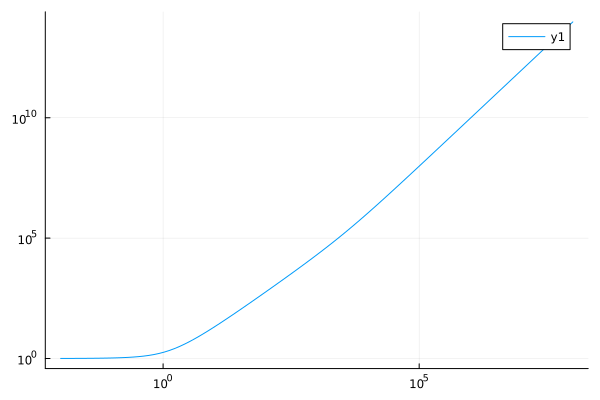

In [13]:
using Plots

z = 10 .^(range(-2,stop=8,length=100))

println(PLANCK18.Ω_m0, " ", PLANCK18.Ω_r0, " ", PLANCK18.Ω_Λ0)

Ω_r = MyCosmology.Ω_r.(z)
Ω_m = MyCosmology.Ω_m.(z)
Ω_Λ = MyCosmology.Ω_Λ.(z)

ρ_r = MyCosmology.ρ_r_Msun_Mpc3.(z)
ρ_m = MyCosmology.ρ_m_Msun_Mpc3.(z)
ρ_Λ = MyCosmology.ρ_Λ_Msun_Mpc3.(z)
ρ_c = MyCosmology.ρ_c_Msun_Mpc3.(z)

#plot(z, Ω_r)
plot(z, MyCosmology.hubble_evolution.(z), yscale=:log10)
#plot!(z, Ω_m)
#plot!(z, Ω_Λ)
plot!(size=(600, 400), xscale=:log10,  minorgrid=false)

In [4]:
using BenchmarkTools
include("../src/Halos.jl")

Halos.cΔ_from_ρs(10 * Msun / kpc^3)
Halos.ρs_from_cΔ(10)
Halos.rs_from_cΔ_and_mΔ(10., 10. * Msun)
h = Halos.Halo_from_mΔ_and_cΔ(Halos.NFWProfile, 1e+12 * Msun, 10) 

@benchmark h.ρs

BenchmarkTools.Trial: 10000 samples with 992 evaluations.
 Range (min … max):  39.987 ns …  2.670 μs  ┊ GC (min … max): 0.00% … 98.18%
 Time  (median):     41.666 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   44.458 ns ± 71.456 ns  ┊ GC (mean ± σ):  5.07% ±  3.10%

  ▃▆▅▂ ▁ ▆█▄▁▁▁ ▂▄▂▁▁▂▃▂▃▃▁                                   ▂
  ██████▇███████████████████▇▇▇▇▆▇▆▇▅▆▇▆▇▆▆▅▅▅▃▄▄▄▄▅▃▄▃▄▅▄▄▄▃ █
  40 ns        Histogram: log(frequency) by time        52 ns <

 Memory estimate: 48 bytes, allocs estimate: 2.

In [ ]:
using NLsolve
using BenchmarkTools

function f!(F, x)
    F[1] = (x[1]+3)*(x[2]^3-7)+18
    F[2] = sin(x[2]*exp(x[1])-1)
end

function j!(J, x)
    J[1, 1] = x[2]^3-7
    J[1, 2] = 3*x[2]^2*(x[1]+3)
    u = exp(x[1])*cos(x[2]*exp(x[1])-1)
    J[2, 1] = x[2]*u
    J[2, 2] = u
end

nlsolve(f!, j!, [ 0.1; 1.2])
println(nlsolve(f!, [ 0.1; 1.2]))

func(x, y) = ((x+3)*(y^3-7)+18, sin(y*exp(x)-1))
println(func(0, 1))

In [ ]:
using Unitful
import Unitful: km, s, Gyr, rad
import UnitfulAstro: Mpc, Gpc, Msun, kpc, pc

D1 = 3.0 
D2 = 6.0 
DS = 8.0 

M1 = 100.0
M2 = 100.0

# For the first test let us imagine everything is in the same plane

y1 = [1e-8, 0.] 
y2 = [0, 1e-8] 

function alpha(x, y, M)
    return 4 .* M * (x .- y) ./ sum((x .- y) .* (x .- y)) * 4.3e-6 / (3e+6)^2  
end

function f!(F, x)
    F[1] = x[1] -  D1 * (1. - D1/DS) * alpha([x[1], x[2]], y1, M1)[1] + D1 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[1]
    F[2] = x[2] -  D1 * (1. - D1/DS) * alpha([x[1], x[2]], y1, M1)[2] + D1 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[2]
    F[3] = x[3] -  D2 * (D1/D2 - D2/DS) * alpha([x[1], x[2]], y1, M1)[1] + D2 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[1]
    F[4] = x[4] -  D2 * (D1/D2 - D2/DS) * alpha([x[1], x[2]], y1, M1)[2] + D2 * (1. - D2/DS)*alpha([x[3], x[4]], y2, M2)[2]
end

function theta(x, D1)
    return x[1:2] ./ D1 * 206265e+6
end

res = nlsolve(f!, [0., 0., 0., 0.]).zero

println(theta(res, D1))


In [3]:
using Unitful
import Unitful: Length, Density, Mass
import UnitfulAstro: Mpc, Gpc, Msun, kpc, pc
using BenchmarkTools

abstract type MyType{T<:Real} end

struct MyOwnSubType{T<:Real} <: MyType{T}
    a::T
    b::T
end

MyOwnSubType(a::Real, b::Real) = MyOwnSubType(promote(a, b)...)
example_a::MyType = MyOwnSubType(1.2, 3)

MyOwnSubType{Float16} <: MyType

struct Halo{T<:Real}
    ρs::Density{T}
    rs::Length{T}
end

ρs_0 = Msun / kpc^3
rs_0 = kpc

#Halo(ρs::Density{<:Real}, rs::Length{<:Real}) = Halo(promote(ρs/ρs_0, rs/rs_0)...)
#Halo(ρs::Real, rs::Real) = Halo(promote(ρs, rs)...)

halo = Halo(1.2 * Msun / kpc^3, 4.0 * kpc)

println(halo)

mass(h::Halo) = 4. / 3. * pi * h.ρs * h.rs^3 #* Msun 

@benchmark mass(halo)


Halo{Float64}(1.2 M⊙ kpc⁻³, 4.0 kpc)


BenchmarkTools.Trial: 10000 samples with 977 evaluations.
 Range (min … max):  69.004 ns …  1.313 μs  ┊ GC (min … max): 0.00% … 94.10%
 Time  (median):     74.378 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   77.609 ns ± 34.445 ns  ┊ GC (mean ± σ):  1.38% ±  2.94%

  ▂▃    ▂ ▂▂██▂▂▃▄▆▄▂▂▃▄▆▃▁▁▁▁▁▁                              ▂
  ██▅▄▅▅██████████████████████████▇▇▇▇▆▆▆▆▆▅▆▄▅▆▆▅▃▅▅▄▃▄▃▄▅▄▃ █
  69 ns        Histogram: log(frequency) by time        97 ns <

 Memory estimate: 48 bytes, allocs estimate: 3.

In [12]:
using Unitful

length_value = 5.0
mass_value = 2.0

length = length_value * u"m"
mass = mass_value * u"kg"

promoted_type = promote_type(eltype(length), eltype(mass))
promoted_length = promote(length, promoted_type)
promoted_mass = promote(mass, promoted_type)


ErrorException: promotion of types Quantity{Float64, 𝐋, Unitful.FreeUnits{(m,), 𝐋, nothing}} and UnionAll failed to change any arguments

(Float64, Real)